# Will try to use the Bird plate boundary table to determine if plate boundary is on-land or under water

Created and tested by A. Newman on 9/01/2022

## Map first

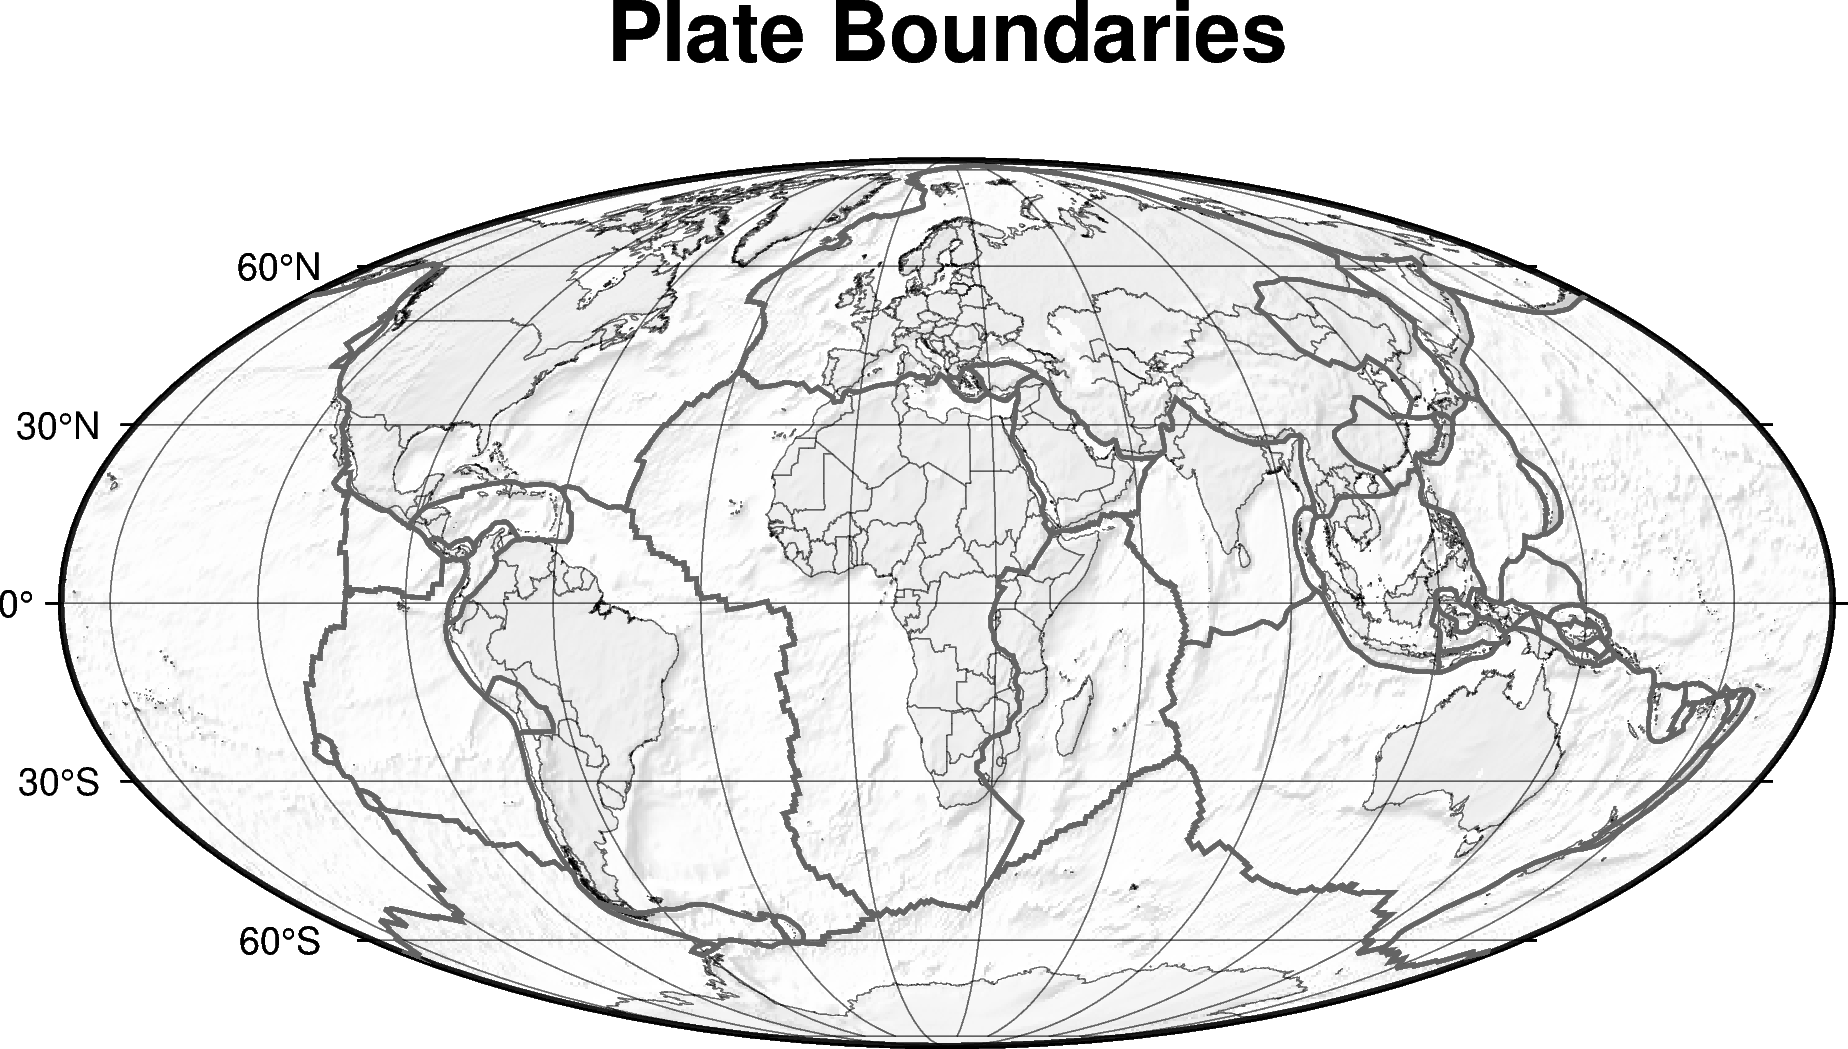

In [16]:
import pygmt,os
scale=15
clon=20
libdir=os.path.join(os.getcwd(),'mapdata')
grid = pygmt.datasets.load_earth_relief(resolution="30m")

#Plates
plates=os.path.join(libdir,'PB2002_plates.txt') # global plate DB
proj="W"+str(clon)+"/"+str(scale)+"c" 
mapcpt=os.path.join(libdir,'map_gray.cpt') # use my favorite light shade


fig1=pygmt.Figure()
fig1.coast(projection=proj,  #pacific-centric w/o chopping Africa
           frame=['WSen+tPlate Boundaries','xa30', 'ya30'], 
           water='white',land='white', shorelines='1/0p,white',
           region='g',
           resolution='c'
          )

fig1.grdimage(grid=grid, cmap=mapcpt, shading=True, 
                  projection=proj,transparency=70)
fig1.coast(projection=proj,  #pacific-centric w/o chopping Africa
           frame=['WSen+tPlate Boundaries','xag30', 'yag30'], 
           shorelines='1/0.2p',
           resolution='l', 
           borders=1,
           transparency=40
          )
fig1.plot(data=plates, pen='1,100', transparency=0)

fig1.show()

In [2]:
# read db
import pandas as pd
platedf=pd.read_csv(plates,delimiter='\s+',skiprows=10,comment='>',names=['Long','Lat'])

# IS land?
# found on stack exchange
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep
land_shp_fname = shpreader.natural_earth(resolution='50m',
                    category='physical', name='land')

land_geom = unary_union(list(shpreader.Reader(land_shp_fname).geometries()))
land = prep(land_geom)

# define is_land
def is_land(x, y):
    return land.contains(sgeom.Point(x, y))

In [3]:
nland=0; nsea=0
platedf=platedf.assign(IsLand='')

for i, row in platedf.iterrows():
    if is_land(platedf.Long[i],platedf.Lat[i]):
        nland=nland+1
        platedf.at[i,"IsLand"]=True
    else:
        nsea=nsea+1
        platedf.at[i,"IsLand"]=False
        
fracsea=nsea/(nsea+nland)*100 
fracland=nland/(nsea+nland)*100 

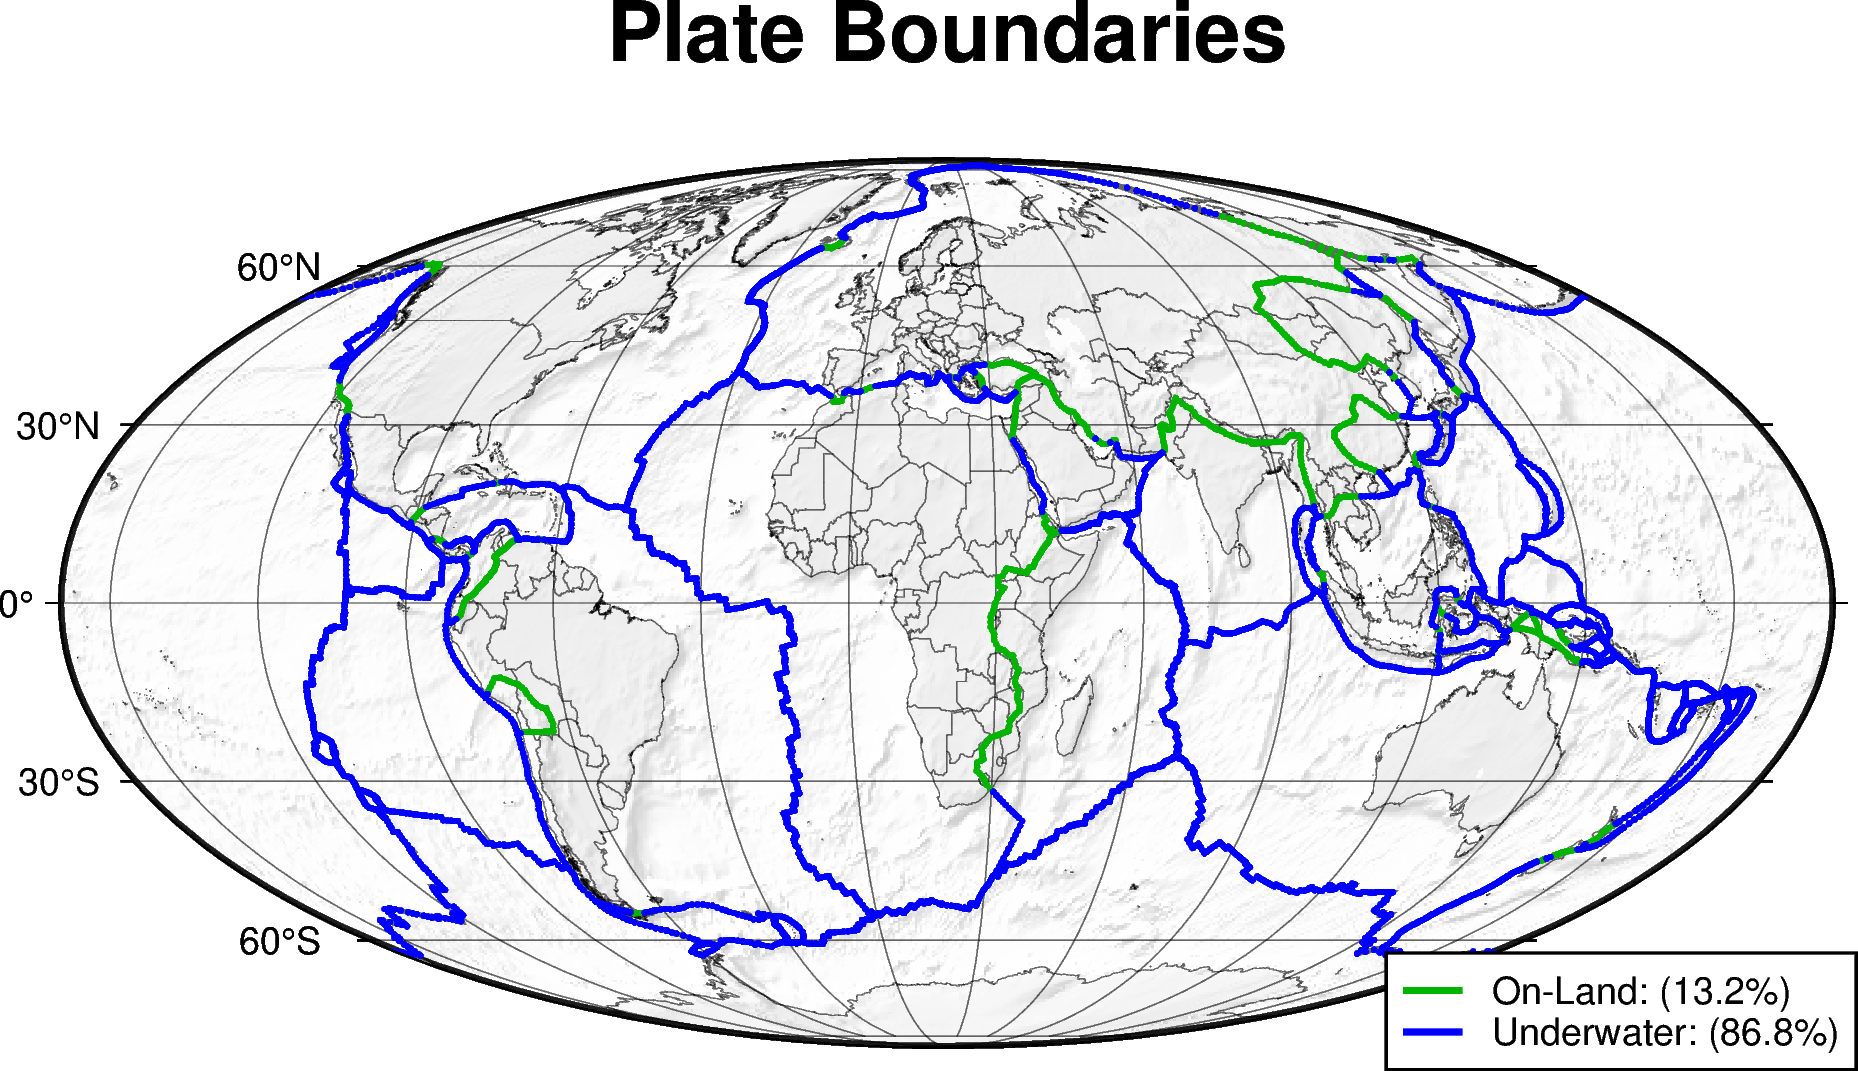

In [17]:
sz=0.05
dgreen='0/180/0'
fig1.plot(platedf[platedf['IsLand']==True], 
          style='p'+str(sz)+'c', color=dgreen, transparency=0)
fig1.plot(platedf[platedf['IsLand']==False], 
          style='p'+str(sz)+'c', color='blue', transparency=0)

# lines just for legend (plotting under legend)
fig1.plot(x=195,y=-70,pen='1.5p,'+dgreen, 
          label="On-Land: ("+"%.1f" % fracland +"\%)")
fig1.plot(x=195,y=-70,pen='1.5p,blue', 
          label="Underwater: ("+"%.1f" % fracsea +"\%)")

fig1.legend(position='JBR+jBR+o-0.2c',
           box='+gwhite+p0.7p',
           )
fig1.show()

In [18]:
fig1.savefig('UnderWater_PlateBoundaries.png',
            dpi=600,
            anti_alias=True,
            #transparent=True,
            show=True)